In [1]:
import sys
sys.path.append('/public/src')
from factor_evaluation_server import FactorEvaluation,DataService # type: ignore
import numpy as np
import pandas as pd

In [2]:
ds=DataService()
df=ds['ETHUSDT_15m_2020_2025']['2021-10-01':]

In [3]:
evaluator=FactorEvaluation(df=df,future_return_periods=10)

# 定义因子！

In [19]:
def factor(df, window_size = 960, threshold_value = 0.2, beta = 1.7):
    """
    改进的 聪明钱因子 (S = |R|/V^β)
    计算步骤:
    1. 计算每根K线的平均价和涨跌幅绝对值
    2. 回溯过去10天（960根15分钟K线）的数据
    3. 计算每根K线的S值 = |涨跌幅| / sqrt(成交量)
    4. 按S值降序排序，取成交量累积占比前20%的K线
    5. 计算聪明钱VWAP和整体VWAP
    6. 因子值 = 聪明钱VWAP / 整体VWAP
    """
    # 预计算所有必要值
    avg_price = (df['open'] + df['high'] + df['low'] + df['close']) / 4
    avg_price_vals = avg_price.values
    
    abs_ret = abs((df['close'] - df['open']) / df['open'])
    
    volume = df['volume'].values
        
    # 初始化因子值数组
    factor_values = np.full(len(df), np.nan)
    
    # 预计算S值 (|R|/V^β)
    S_values = abs_ret.values / (volume ** beta)
    
    # 使用滑动窗口计算
    for i in range(window_size, len(df)):
        # 获取当前窗口切片索引
        start_idx = i - window_size
        end_idx = i - 1
        
        # 提取当前窗口数据
        window_avg_price = avg_price_vals[start_idx:end_idx]
        window_volume = volume[start_idx:end_idx]
        window_S = S_values[start_idx:end_idx]
        
        # 按S值降序排序的索引
        sorted_idx = np.argsort(-window_S)
        sorted_volume = window_volume[sorted_idx]
        sorted_avg_price = window_avg_price[sorted_idx]
        
        # 计算累积成交量
        cum_volume = np.cumsum(sorted_volume)
        total_volume = cum_volume[-1]
        threshold = total_volume * threshold_value
        
        # 找到聪明钱交易点 (前20%成交量)
        smart_mask = cum_volume <= threshold
        if np.any(smart_mask):
            smart_vwap = np.sum(sorted_avg_price[smart_mask] * 
                               sorted_volume[smart_mask]) / np.sum(sorted_volume[smart_mask])
        else:
            smart_vwap = np.nan
        
        # 计算整体VWAP
        all_vwap = np.sum(window_avg_price * window_volume) / np.sum(window_volume)
        
        # 计算因子值
        if not np.isnan(smart_vwap) and all_vwap != 0:
            factor_values[i] = smart_vwap / all_vwap
            
    return pd.Series(factor_values, index=df.index)

# 测试因子表现


📊 单币种 (single) 详细评估结果:
--------------------------------------------------
🔗 相关性分析:
   IC (Pearson): -0.000999
   Rank_IC (Spearman): -0.003542
📊 信息比率:
   IR: 0.257716
   有效分组数: 10
📊 因子分布:
📋 数据概况:
   数据长度: 127195
   因子列: factor
   收益率列: future_return
   未来收益周期: 10
--------------------------------------------------

🖼️  单币种 (single) 图片展示:
----------------------------------------
📊 显示分组分析图...


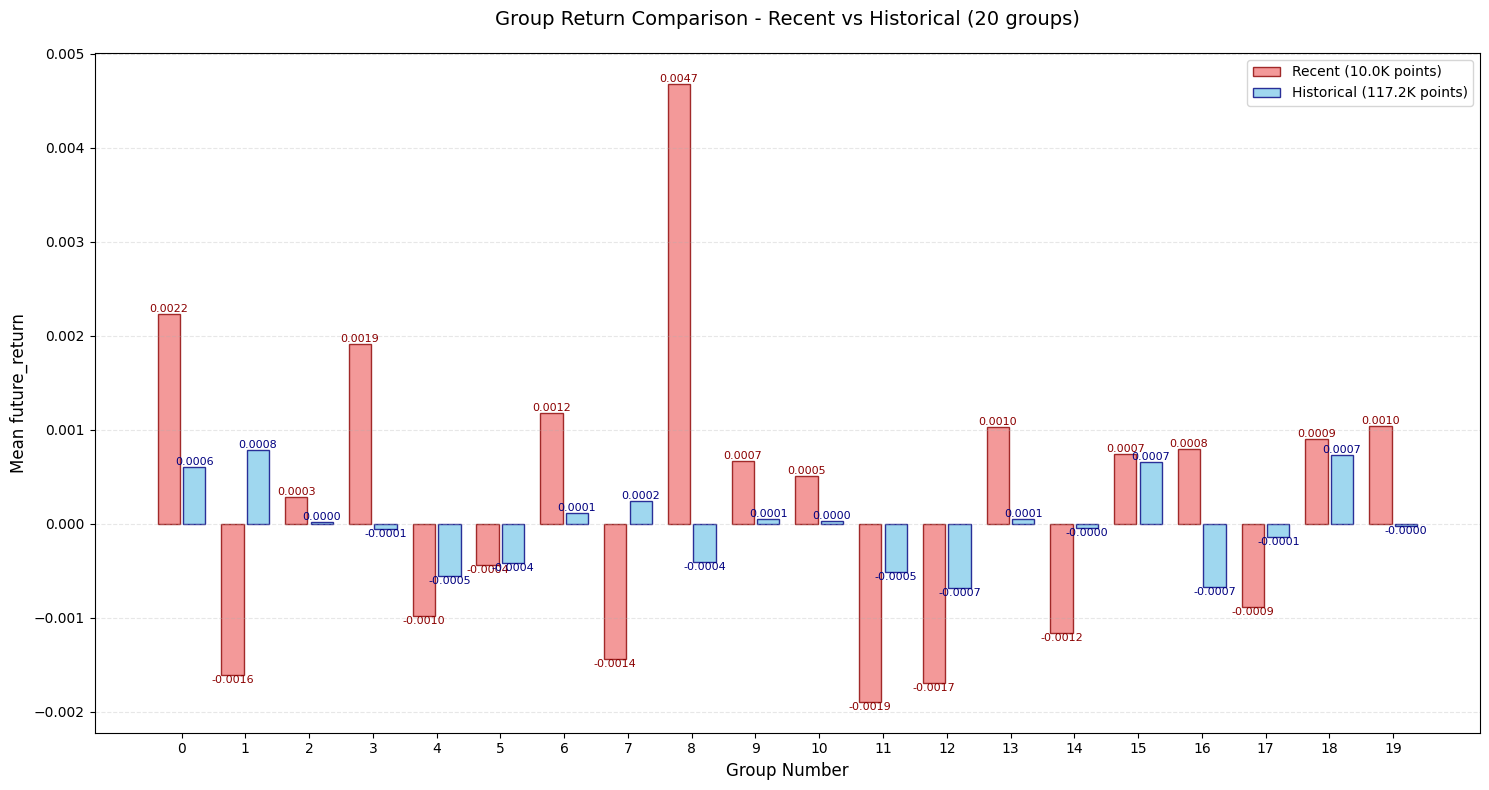

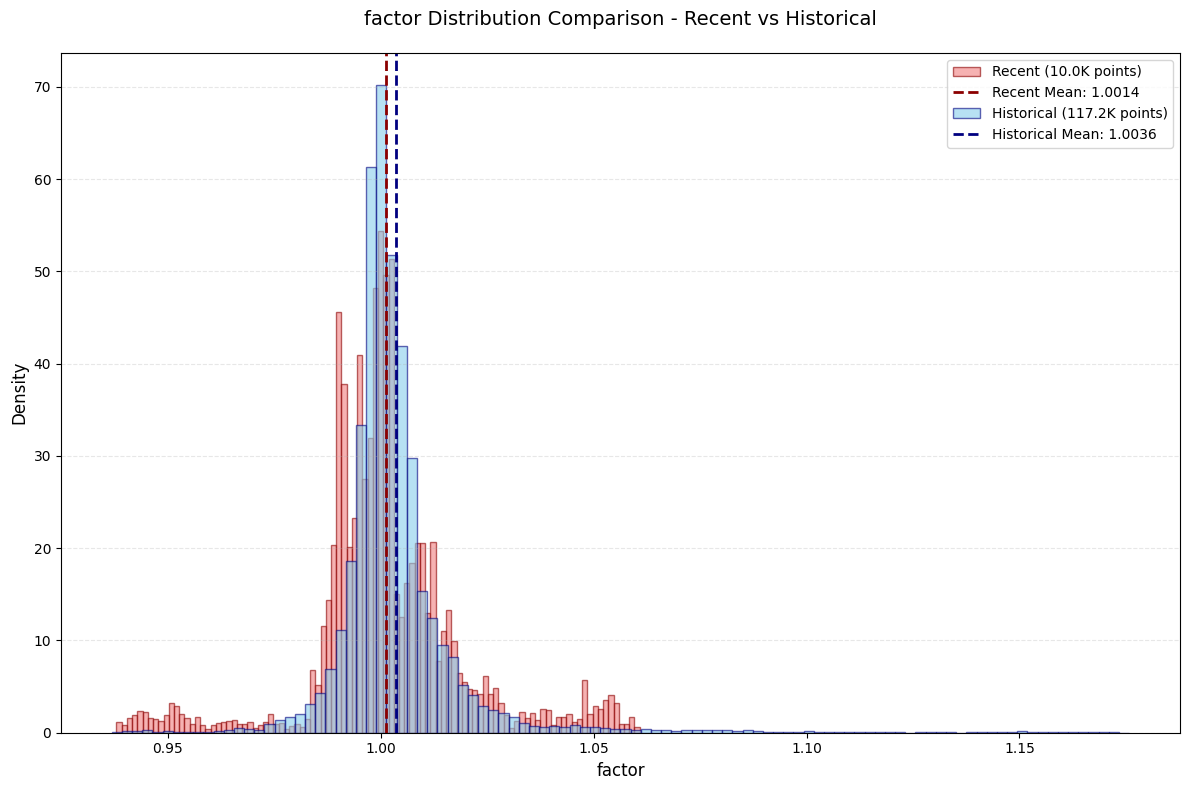

📈 显示因子分布图...
✅ 已显示 2 个图片
----------------------------------------


In [20]:
evaluator.set_factor(
    factor_func=lambda df: factor(df),
    factor_name='factor'
)

result=evaluator.run_full_evaluation(run_stationarity_test=False)

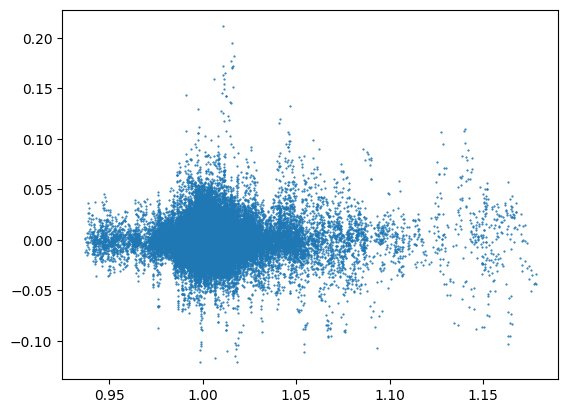

In [16]:
import matplotlib.pyplot as plt
plt.scatter(factor(df),df['close'].pct_change(-10), s=0.3)

In [17]:
result['information_ratio']['group_correlations']
# 这表示不同分组之间的相关性，通常用于评估因子在不同市场状态下的表现一致性。
# 如果相关性较高，说明因子在不同市场状态下表现一致；如果相关性较低，说明因子在不同市场状态下表现差异较大。

[0.0015800754057782099,
 -0.033473092868445735,
 0.017181486275090457,
 -0.02378360315445531,
 0.019958907351615728,
 -0.024692461142798335,
 -0.007487569625661846,
 0.021496573214320233,
 0.03388128155044517,
 -0.001454084417073363]

In [18]:
print(result)

{'correlation_analysis': {'IC': -0.0009099401398770036, 'Rank_IC': -0.001884671217115632}, 'information_ratio': {'IR': 0.01485998750260155, 'group_correlations': [0.0015800754057782099, -0.033473092868445735, 0.017181486275090457, -0.02378360315445531, 0.019958907351615728, -0.024692461142798335, -0.007487569625661846, 0.021496573214320233, 0.03388128155044517, -0.001454084417073363], 'n_groups': 10}, 'group_analysis': {'group_stats':        val_min  val_max  val_mean  return_mean  return_std  count
group                                                            
0       0.9368   0.9883    0.9784       0.0003      0.0116   6408
1       0.9883   0.9924    0.9907       0.0008      0.0111   6408
2       0.9924   0.9948    0.9937       0.0001      0.0101   6408
3       0.9948   0.9962    0.9956      -0.0000      0.0098   6407
4       0.9962   0.9973    0.9968      -0.0005      0.0097   6408
5       0.9973   0.9981    0.9977      -0.0000      0.0100   6408
6       0.9981   0.9988    0.9985